# <center> <img src="../../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> Computer Systems Engineering  </center>
---
### <center> Big Data Processing </center>
---
#### <center> **Autumn 2025** </center>

#### <center> **Final project: Structured Streaming** </center>
---

**Date**: November, 2025

**Student Name**: Jaime Enrique Galindo Villegas

**Professor**: Pablo Camarillo Ramirez

## Producer
Using the application and dataset used in the batch_processing Notebook, you need to write a producer script in python to generate the information in continuous mode. The producer uses a Kafka topic

Producer to kafka: ml_producer.py 

**Crear topic en kafka:**
opt/kafka/bin/kafka-topics.sh --create --zookeeper zookeeper:2181 --replication-factor 1 --partitions 1 --topic &lt;topic&gt;

**Ver topics en kafka:**
opt/kafka/bin/kafka-topics.sh --list --list --zookeeper zookeeper:2181

**Ver mensajes que llegan al topic:**
opt/kafka/bin/kafka-console-consumer.sh --bootstrap-server localhost:9092 --topic &lt;topic&gt;

**Iniciar productor:**
/opt/spark/work-dir/lib/jaime_galindo# python3 ml_producer.py kafka:9093 &lt;topic&gt;


## Consumer
### Dataset and Stream creation

This section should contain the code to create a stream using Spark Structured Streaming API to consume the data in continuous mode from the selected stream channel (files or kafka).  The information you need to consume in this section should contain the schema generation (with the SparkUtils class) and the correct format and reading options.

#### Iniciar sesión de spark

In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
	.appName("MercadoLibreTransformations") \
	.master("spark://spark-master:7077") \
    .config("spark.jars.packages", "org.apache.spark:spark-sql-kafka-0-10_2.13:4.0.0") \
	.config("spark.ui.port", "4040") \
	.getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("INFO")

# Optimization (reduce the number of shuffle partitions)
spark.conf.set("spark.sql.shuffle.partitions", "5")


:: loading settings :: url = jar:file:/opt/spark/jars/ivy-2.5.3.jar!/org/apache/ivy/core/settings/ivysettings.xml
Ivy Default Cache set to: /root/.ivy2.5.2/cache
The jars for the packages stored in: /root/.ivy2.5.2/jars
org.apache.spark#spark-sql-kafka-0-10_2.13 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-5d16705f-ba74-4cc7-a48a-f413bb3d937d;1.0
	confs: [default]
	found org.apache.spark#spark-sql-kafka-0-10_2.13;4.0.0 in central
	found org.apache.spark#spark-token-provider-kafka-0-10_2.13;4.0.0 in central
	found org.apache.kafka#kafka-clients;3.9.0 in central
	found org.lz4#lz4-java;1.8.0 in central
	found org.xerial.snappy#snappy-java;1.1.10.7 in central
	found org.slf4j#slf4j-api;2.0.16 in central
	found org.apache.hadoop#hadoop-client-runtime;3.4.1 in central
	found org.apache.hadoop#hadoop-client-api;3.4.1 in central
	found com.google.code.findbugs#jsr305;3.0.0 in central
	found org.scala-lang.modules#scala-parallel-collections_2.13;1.2.0

#### Iniciar stream de spark

In [2]:
kafka_df = spark.readStream \
            .format("kafka") \
            .option("kafka.bootstrap.servers", "kafka:9093") \
            .option("subscribe", " structured-streaming") \
            .load()

kafka_df.printSchema()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)



In [3]:

ml_orders = kafka_df.select(kafka_df.value.cast("string").alias("value_str"))


#### Crear esquema y dataset con la información relevante

In [4]:
# Creación del esquema

from pyspark.sql.types import ArrayType # type: ignore
from jaime_galindo.spark_utils import SparkUtils

# Esquemas básicos de cada entidad
user_schema = SparkUtils.generate_schema([
	("user_id", "string"),
	("region", "string"),
	("payment_method", "string")
])

item_schema = SparkUtils.generate_schema([
	("item_id", "string"),
	("title", "string"),
	("category", "string"),
	("quantity", "integer"),
	("unit_price", "double"),
	("final_price", "double"),
	("discount_applied", "boolean")
])

shipping_schema = SparkUtils.generate_schema([
	("logistics_provider", "string"),
	("warehouse_origin", "string"),
	("estimated_delivery", "string"),
	("tracking_id", "string")
])


# Equema principal de la orden
order_schema = SparkUtils.generate_schema([
	("order_id", "string"),
	("timestamp", "string"),
	("user", user_schema),
	("items", ArrayType(item_schema)),
	("total_amount", "double"),
	("shipping", shipping_schema)
])


In [5]:
from pyspark.sql.functions import from_json

ml_extracted_df = ml_orders.withColumn("orders", from_json(ml_orders.value_str, order_schema))

ml_extracted_df.printSchema()   



root
 |-- value_str: string (nullable = true)
 |-- orders: struct (nullable = true)
 |    |-- order_id: string (nullable = true)
 |    |-- timestamp: string (nullable = true)
 |    |-- user: struct (nullable = true)
 |    |    |-- user_id: string (nullable = true)
 |    |    |-- region: string (nullable = true)
 |    |    |-- payment_method: string (nullable = true)
 |    |-- items: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- item_id: string (nullable = true)
 |    |    |    |-- title: string (nullable = true)
 |    |    |    |-- category: string (nullable = true)
 |    |    |    |-- quantity: integer (nullable = true)
 |    |    |    |-- unit_price: double (nullable = true)
 |    |    |    |-- final_price: double (nullable = true)
 |    |    |    |-- discount_applied: boolean (nullable = true)
 |    |-- total_amount: double (nullable = true)
 |    |-- shipping: struct (nullable = true)
 |    |    |-- logistics_provider: string (null

### Transformations and Actions
In this section, you need to provide the code to clean and process data (create new columns, aggregate, run joins, etc.). In this section is NOT expected to have any action.

#### limpieza de datos
separar la información que se tiene en nuevas columnas y nuevas filas para tener la información "plana"

In [6]:
# Transformaciones
from pyspark.sql.functions import col, explode 

# hacer explode para obtener las columnas de cada elemento y filas para cada item
df_with_items = ml_extracted_df.select(
   col("orders.order_id"),
   col("orders.timestamp"),
   col("orders.user"),
   col("orders.total_amount"),
   col("orders.shipping"),

	explode("orders.items").alias("item")
)

# "Aplanar" cada estructura compleja para tener solo los valores y un posterior analisis más eficiente
df_flattened = df_with_items.select(
   col("order_id"),
   col("timestamp"),
   col("total_amount").alias("order_total_amount"),
   
	# Aplanar user
   col("user.user_id"),
   col("user.region"),
   col("user.payment_method"),
   
	# Aplanar shipping,
   col("shipping.logistics_provider"),
   col("shipping.warehouse_origin"),
   col("shipping.estimated_delivery"),
   col("shipping.tracking_id"),
   
	# Aplanar item,
	col("item.item_id"),
	col("item.title"),
	col("item.category"),
	col("item.quantity"),
	col("item.unit_price"),
	col("item.final_price"),
	col("item.discount_applied")

)


#### Procesar los datos
Crear nuevas columnas en base a la información existente para enriquecer la información

In [7]:
from pyspark.sql.functions import current_timestamp, year, month, dayofmonth
from pyspark.sql.types import TimestampType

# Enriquecimiento, crear nuevas columnas para agregar valor a los datos
# Se convierte la columna timestamp de texto simple a tipo Timestamp de spark
# Se crean nuevos datos calculados de cada item y se separa el tiempo en año, mes, dia para futuro analisis 
df_enriched = df_flattened \
	.withColumn("order_date", col("timestamp").cast(TimestampType())) \
	.withColumn("estimated_delivery_date", col("estimated_delivery").cast(TimestampType())) \
	.withColumn("item_total_price", col("final_price") * col("quantity")) \
	.withColumn("item_total_discount", (col("unit_price") - col("final_price")) * col("quantity")) \
	.withColumn("processing_timestamp", current_timestamp()) \
	.withColumn("year", year(col("order_date"))) \
	.withColumn("month", month(col("order_date"))) \
	.withColumn("day", dayofmonth(col("order_date"))) \
	.drop("timestamp") \
	.drop("estimated_delivery")


### Persistence Data
Once information is transformed, you need to document the process of persistence data in files using at least one vertical partition (partitionBy).  

In [ ]:
# Dejaré corriendo durante mas de ~1h para obtener bastante información historica para Power BI
query_files = df_enriched.writeStream \
					.trigger(processingTime="1 minute") \
					.partitionBy("year", "month", "day") \
					.format("parquet") \
					.option("header", "true") \
					.option("path", "/opt/spark/work-dir/data/mlibre_stream_output/") \
					.option("checkpointLocation", "/opt/spark/work-dir/data/mlibre_stream_checkpoint") \
					.start()


25/11/15 23:48:42 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


In [9]:
query_files.stop()

25/11/15 23:51:10 WARN DAGScheduler: Failed to cancel job group e5103ca2-1a62-4732-9ed3-eb06dca3d978. Cannot find active jobs for it.
25/11/15 23:51:10 WARN DAGScheduler: Failed to cancel job group e5103ca2-1a62-4732-9ed3-eb06dca3d978. Cannot find active jobs for it.


### Power BI Dashboard 
With the files generated in the persistence section, you should create a Dashboard using Power BI to summarize and visualize the information you processed in the Data Pipeline

Imagen del dashboard en general:
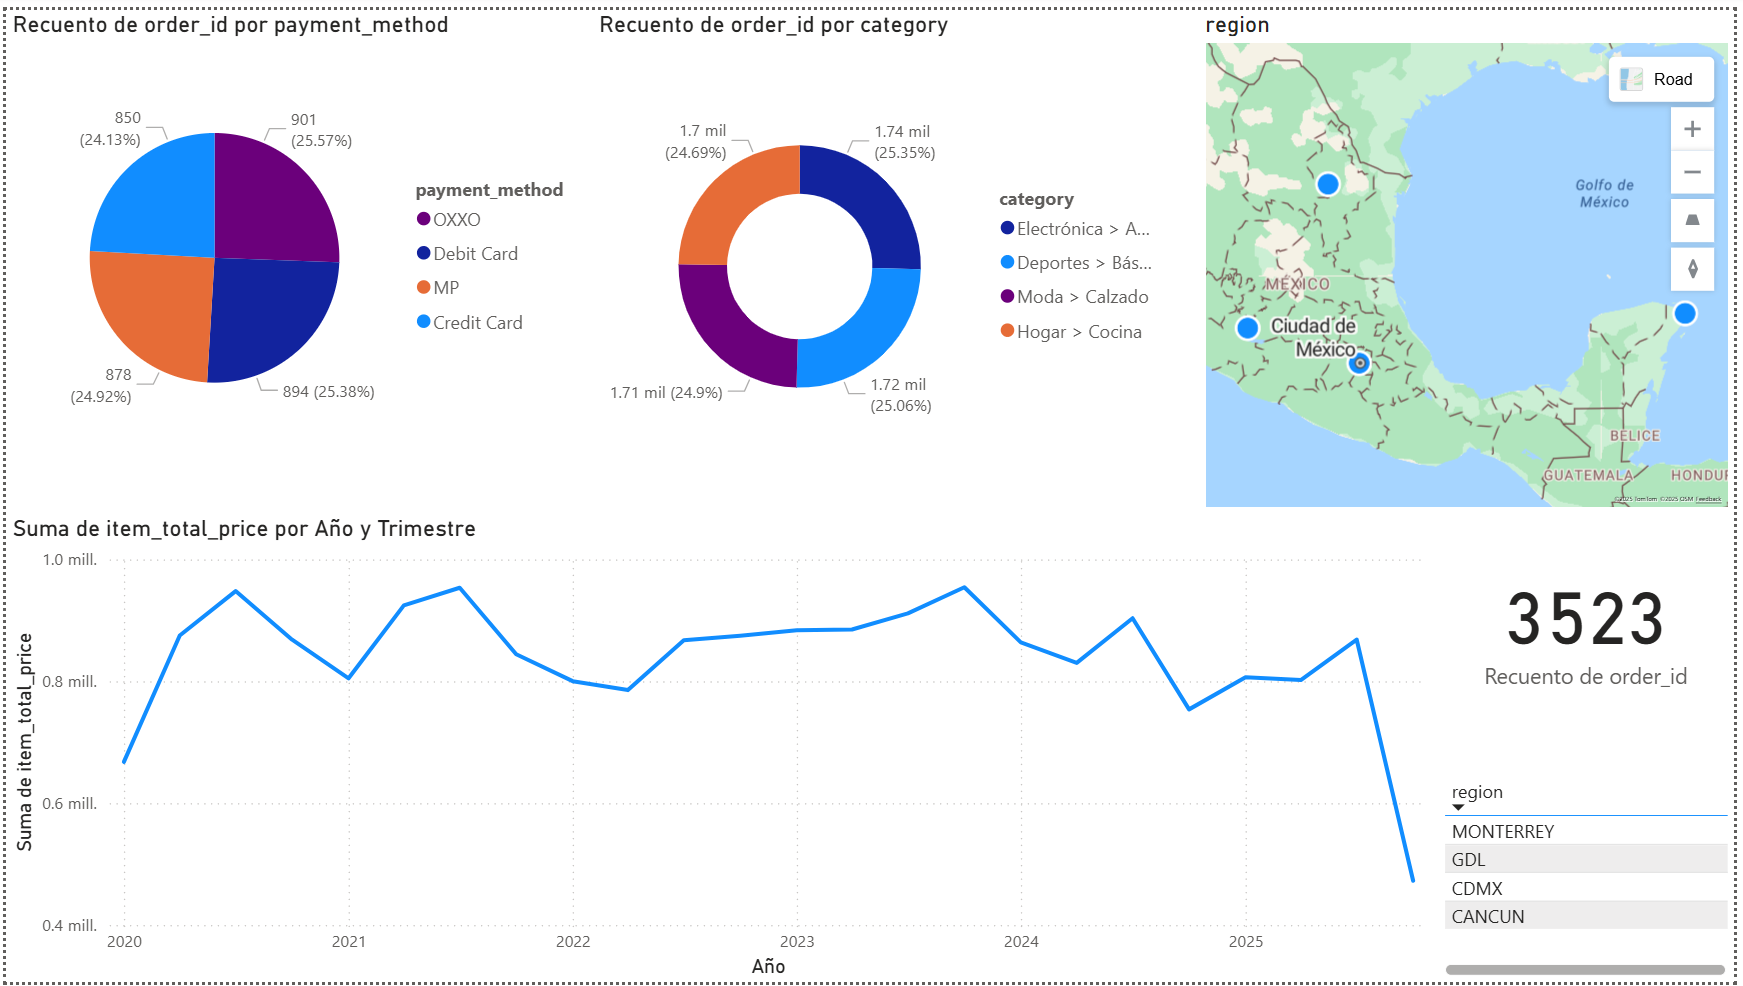


Filtro por region:
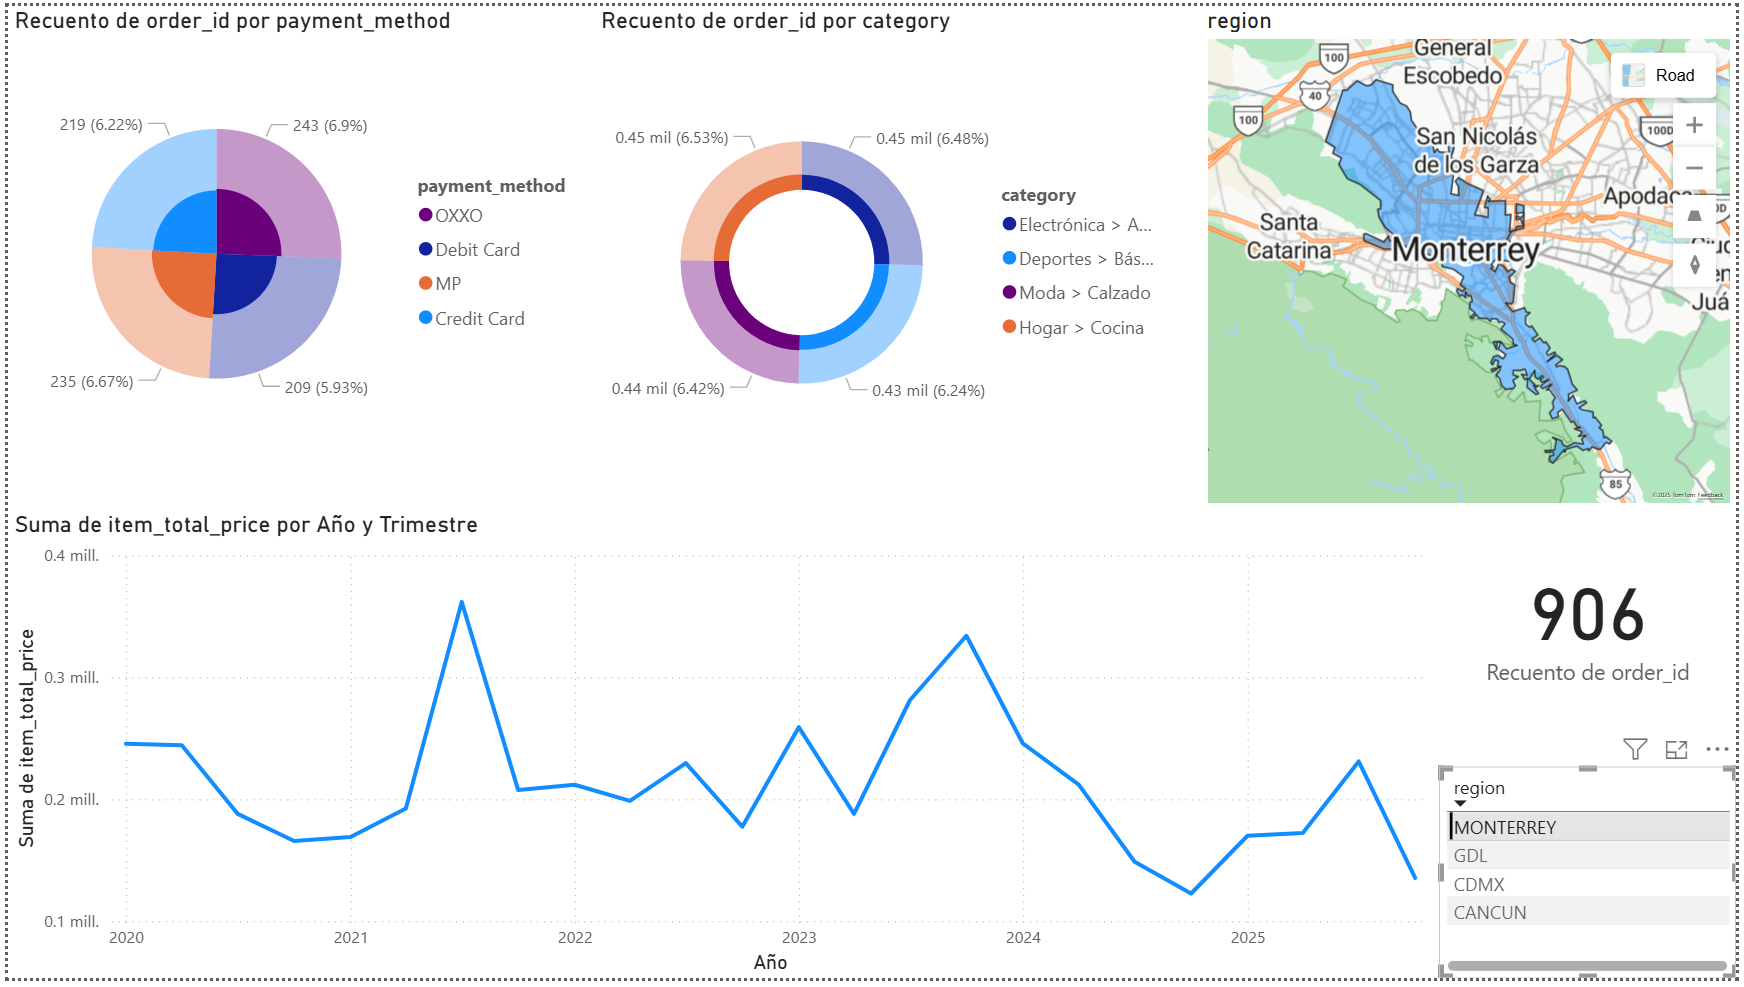

Filtro por categoria:
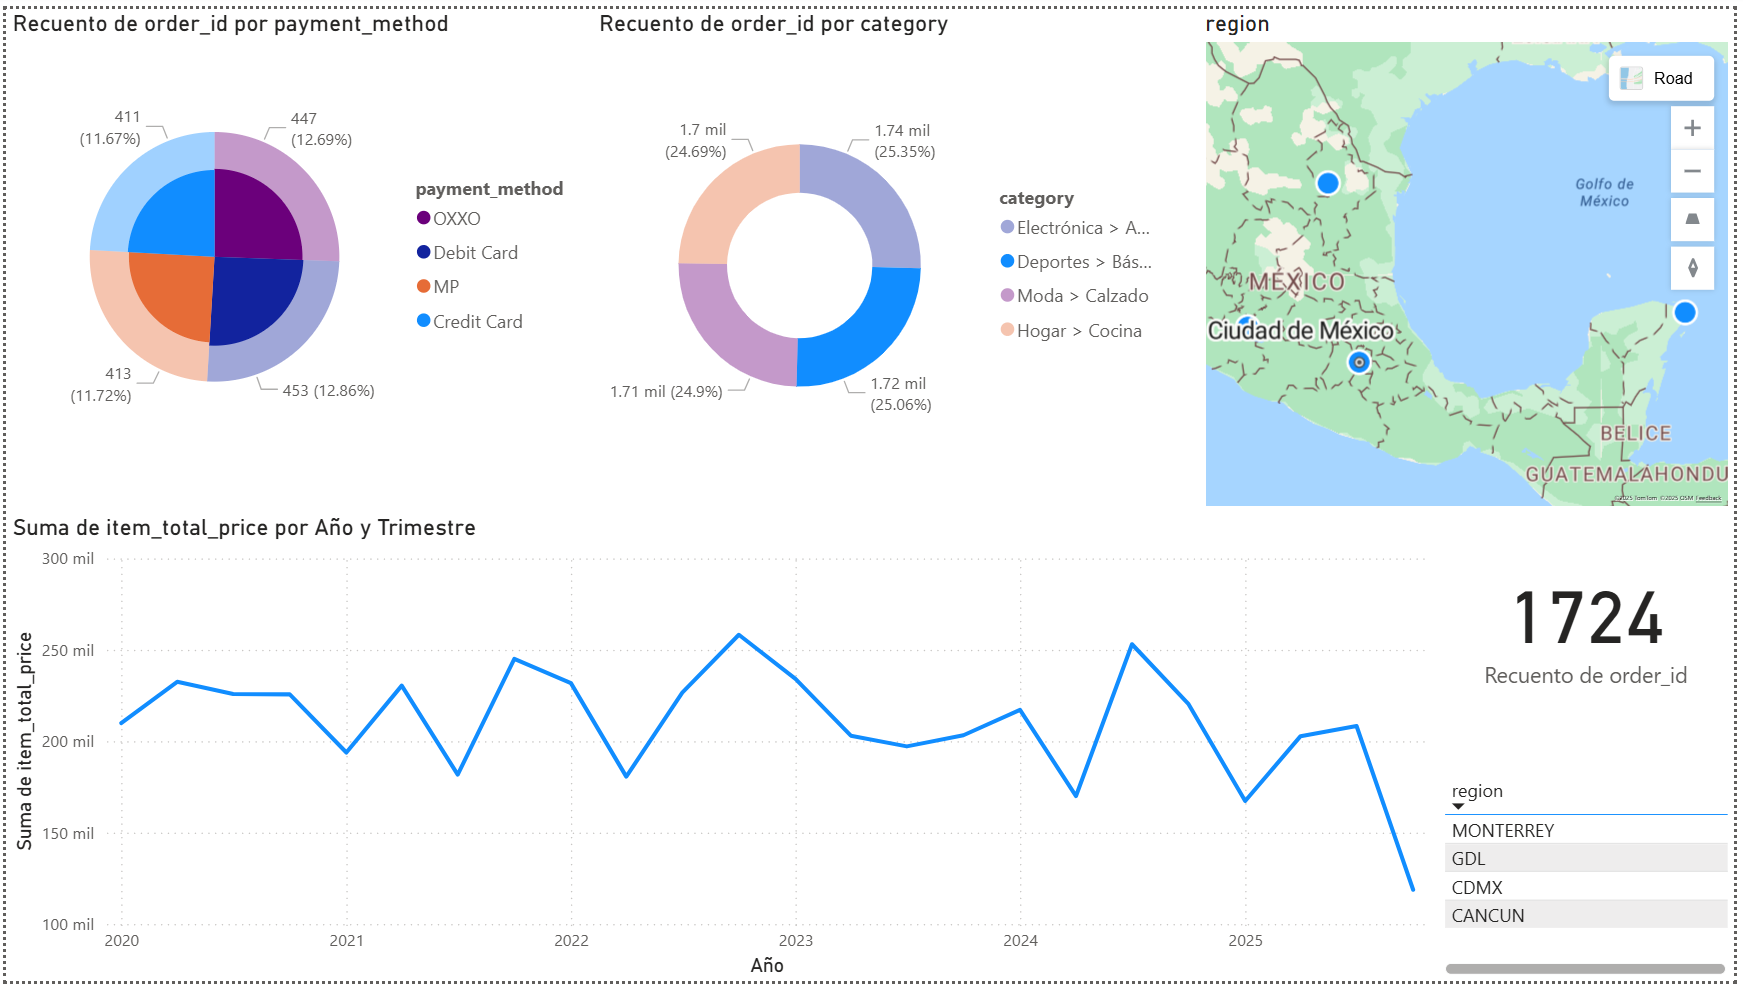



In [10]:
sc.stop()